## Imports & setup

In [248]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs

from geomstats.geometry.pullback_metric import PullbackMetric

import matplotlib.pyplot as plt

import neuralgeom.datasets.gridcells as gridcells
from viz import plot_grid_rate_maps, plot_grids
import numpy as np

import setup
setup.main()

%load_ext autoreload
%autoreload 2
%matplotlib inline

Working directory:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define diffeomorphism $\varphi: \mathbb{R}^2 \to \mathbb{R}^2$

In [271]:
def get_plane_warp(alpha, beta, gamma):
    
    def plane_warp(point):
        x = point[0]
        y = point[1]
        
        f_x = (1 + gamma/(1 + x**2 + y**2)**alpha)*x
        f_y = (1 + gamma/(1 + x**2 + y**2)**beta)*y
        
        f_point = gs.array([f_x,f_y])
        
        return f_point
    
    return plane_warp

### Instantiate + plot warp

In [288]:
warp = get_plane_warp(alpha=1, beta=1, gamma=-0.8)

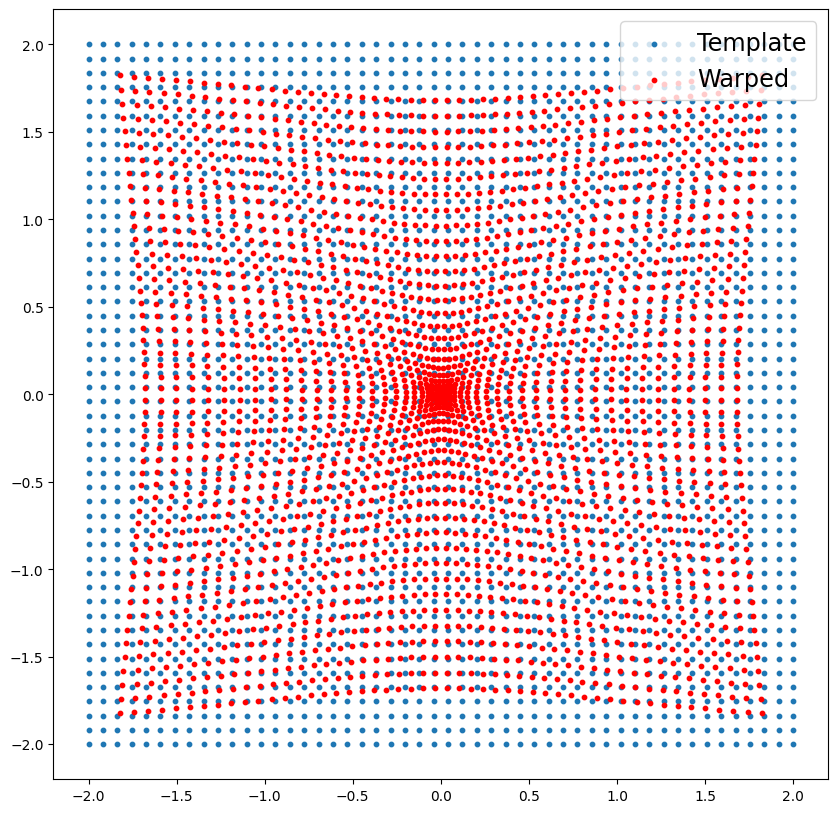

In [289]:
x = gs.linspace(-2,2,50)
y = gs.linspace(-2,2,50)
x_grid, y_grid = gs.meshgrid(x,y)
x_grid_warp, y_grid_warp = warp((x_grid,y_grid))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(x_grid,y_grid, s=10, label="Template")
ax.scatter(x_grid_warp,y_grid_warp,s=10, label="Warped", c= "red")
ax.legend(fontsize="xx-large")

## Compute pull-back metric $(\varphi^*g)_{ij} = \partial_{i}\varphi^{a}\partial_{j}\varphi^{b}g_{ab}$

In [290]:
pullback_metric = PullbackMetric(dim=2,embedding_dim=2,immersion=warp)

### Quick distance check 

In [283]:
point_a = gs.array([0.0,0.0])
point_b = gs.array([1.0,1.0])
pullback_metric.dist(point_a,point_b)

tensor(1.1197)

### Quick metric matrix check

In [241]:
pullback_metric.metric_matrix(point_a)

tensor([[0.0400, 0.0000],
        [0.0000, 0.0400]])

## Plot volume element $\sqrt{|\text{det}(g)|}$

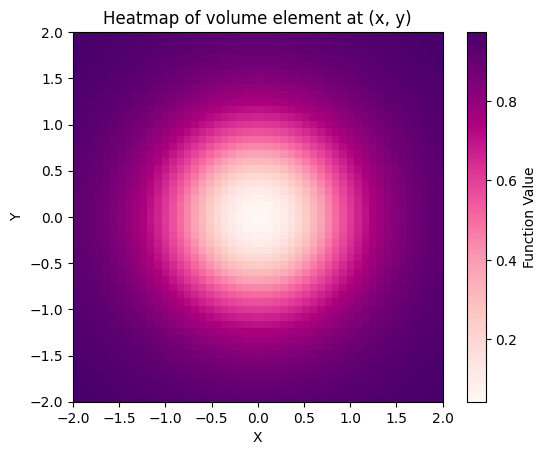

In [291]:
# Combine and reshape the x and y coordinates into a list of 2D points
points = gs.vstack((x_grid.ravel(), y_grid.ravel())).T

# Define your function
def volume_element(x, y):
    point = gs.array([x,y])
    g = pullback_metric.metric_matrix(point)
    vol = gs.sqrt(gs.abs(gs.linalg.det(g)))
    return vol

# Apply the function to each point in the list
values = gs.array([volume_element(x, y) for x, y in points])

# Reshape the values back into a 2D grid
z_values = values.reshape(x_grid.shape)

# Create the heatmap
plt.imshow(z_values, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='RdPu')
plt.colorbar(label='Function Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of volume element at (x, y)')
plt.show()

## TODO -- Visualize geodesic grid

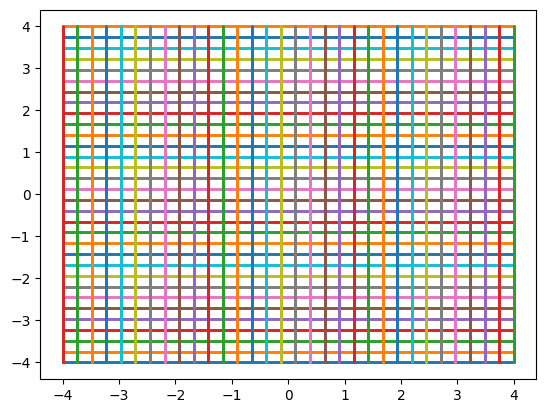

In [49]:
"""Plot a grid on H2 with Poincare Disk visualization."""

import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hyperboloid import Hyperboloid

# H2 = Hyperboloid(dim=2)
# METRIC = H2.metric

from geomstats.geometry.euclidean import Euclidean

R2 = Euclidean(dim=2)
METRIC = R2.metric

left=-4.0
right=4.0
bottom=-4.0
top=4.0
grid_size=32
n_steps=512


"""Plot a grid on H2 with Poincare Disk visualization.

Parameters
----------
left, right, bottom, top : ints
    Grid's coordinates
grid_size : int
    Grid's size.
n_steps : int
    Number of steps along the geodesics defining the grid.
"""
starts = []
ends = []
for p in gs.linspace(left, right, grid_size):
    starts.append(gs.array([top, p]))
    ends.append(gs.array([bottom, p]))
for p in gs.linspace(top, bottom, grid_size):
    starts.append(gs.array([p, left]))
    ends.append(gs.array([p, right]))
    
# starts = [H2.from_coordinates(s, "intrinsic") for s in starts]
# ends = [H2.from_coordinates(e, "intrinsic") for e in ends]
ax = plt.gca()
for start, end in zip(starts, ends):
    geodesic = METRIC.geodesic(initial_point=start, end_point=end)

    t = gs.linspace(0.0, 1.0, n_steps)
    points_to_plot = geodesic(t)
    # visualization.plot(
    #     points_to_plot, ax=ax, space="H2_poincare_disk", marker=".", s=1
    # )
    plt.scatter(points_to_plot[:,0],points_to_plot[:,1], s=1)

## Synthetic grid cell deformations

### Grid cell parameters

In [292]:
grid_scale = 1
arena_dims = np.array([4, 4])
n_cells = 4
grid_orientation_mean = 0
grid_orientation_std = 0
field_width = 0.05
resolution = 100
lx = grid_scale
ly = grid_scale * np.sqrt(3) / 2

### Create grid + deformed grid

In [293]:
grids, grids_warped = gridcells.generate_all_grids(
    grid_scale, arena_dims, n_cells, grid_orientation_mean, grid_orientation_std, warp=warp)

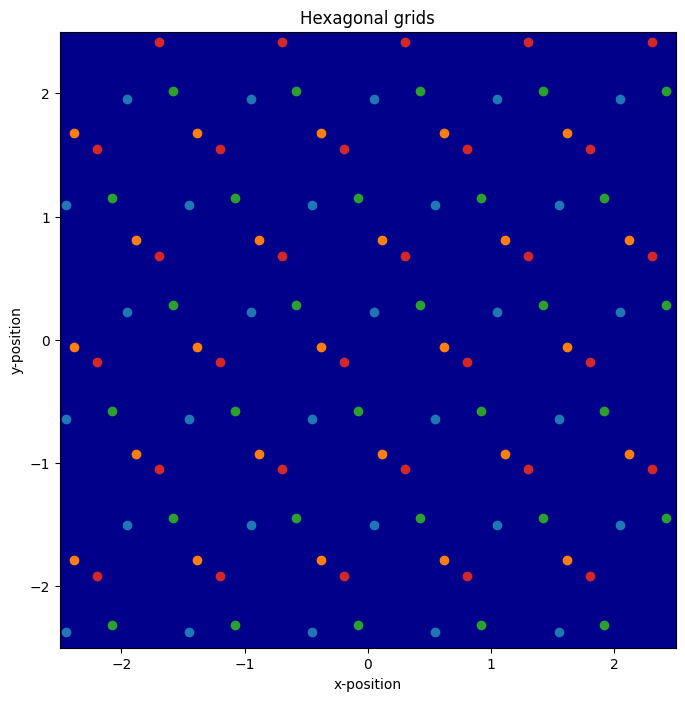

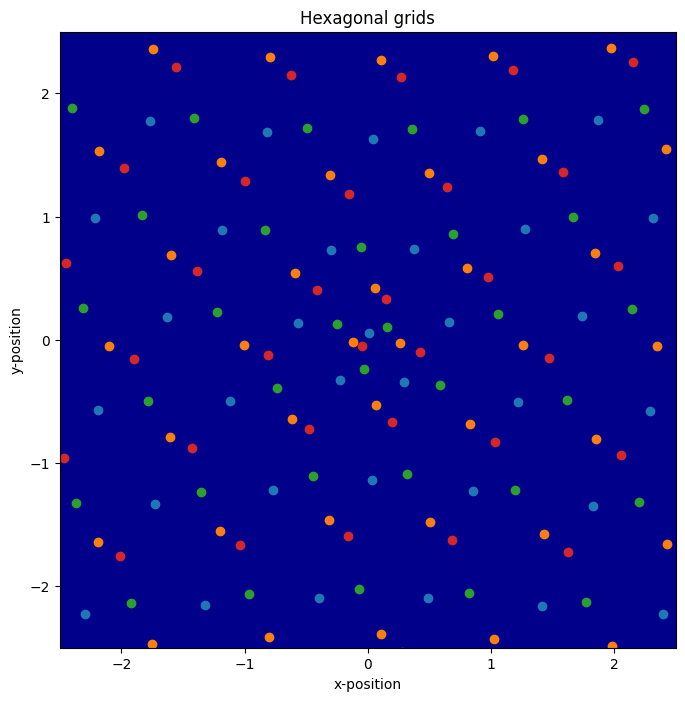

In [294]:
plot_grids(grids, arena_dims)
plot_grids(grids_warped, arena_dims)

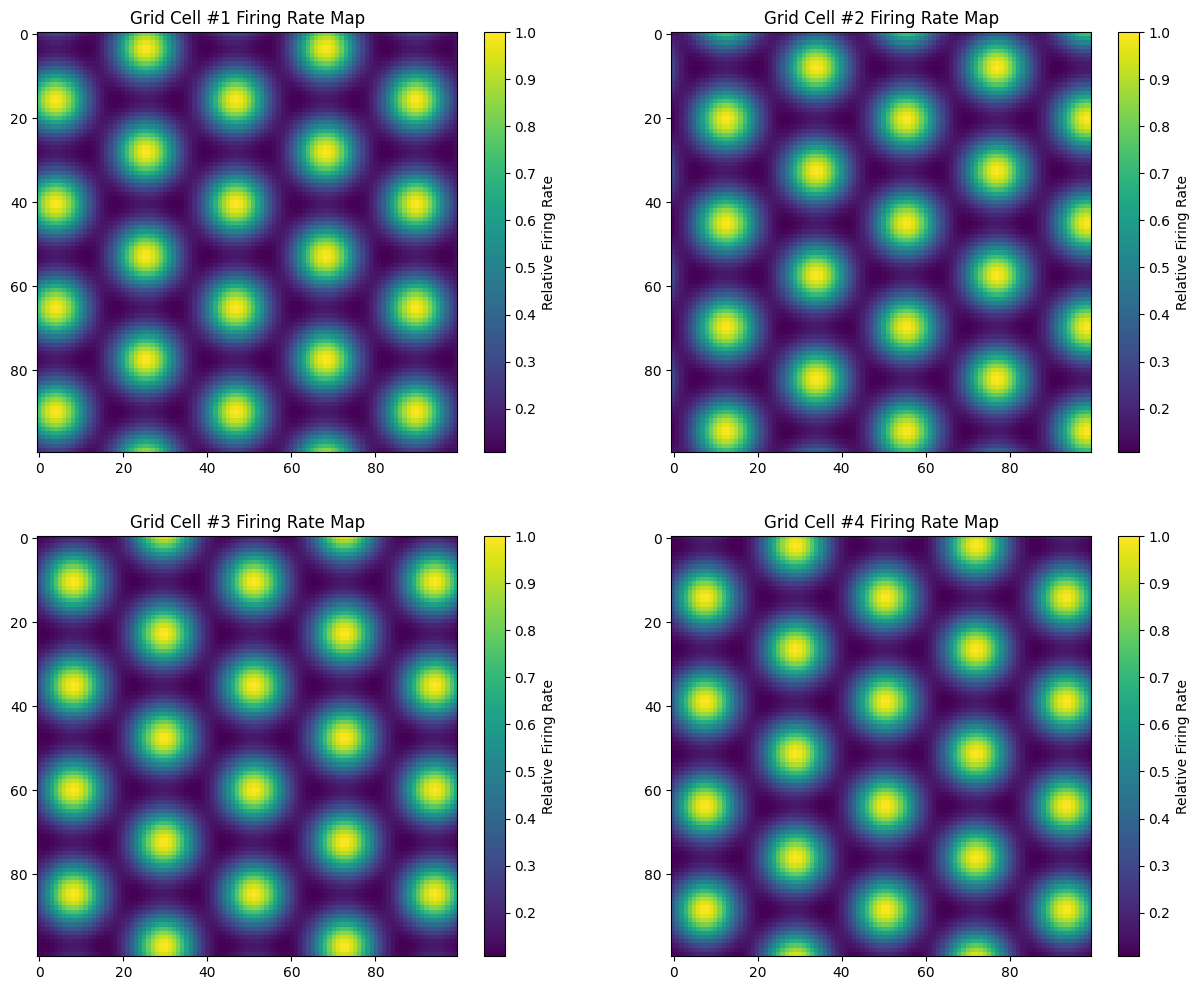

In [268]:
rate_maps = gridcells.create_rate_maps(grids, field_width, arena_dims, resolution)
plot_grid_rate_maps(rate_maps)

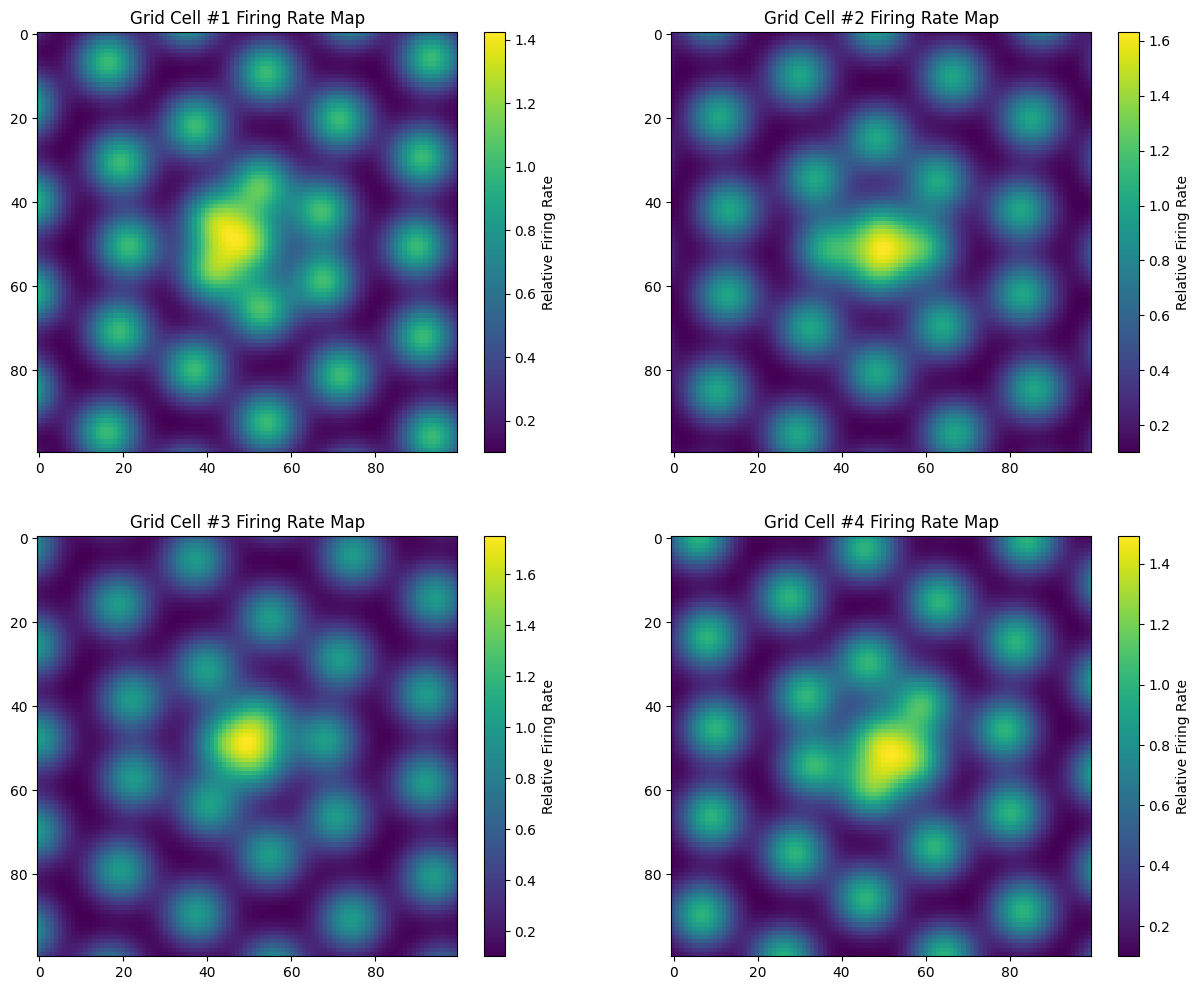

In [295]:
rate_maps_warped = gridcells.create_rate_maps(grids_warped, field_width, arena_dims, resolution)
plot_grid_rate_maps(rate_maps_warped)

In [315]:
import sys
sys.path.append(os.getcwd() + "/neuralwarp/pyLDDMM/")
import pyLDDMM
from neuralgeom.pyLDDMM.utils.visualization import loadimg, saveimg, save_animation, plot_warpgrid

ModuleNotFoundError: No module named 'pyLDDMM.utils'